In [157]:
!pip install --upgrade shapely

In [105]:
import geopandas as gpd

lsoa_path = 'Data/GIS/LSOA/LSOA_2011_London_gen_MHW.shp'
lsoa = gpd.read_file(lsoa_path)
lsoa = lsoa.to_crs(epsg=27700)

print("New CRS:", lsoa.crs)

New CRS: EPSG:27700


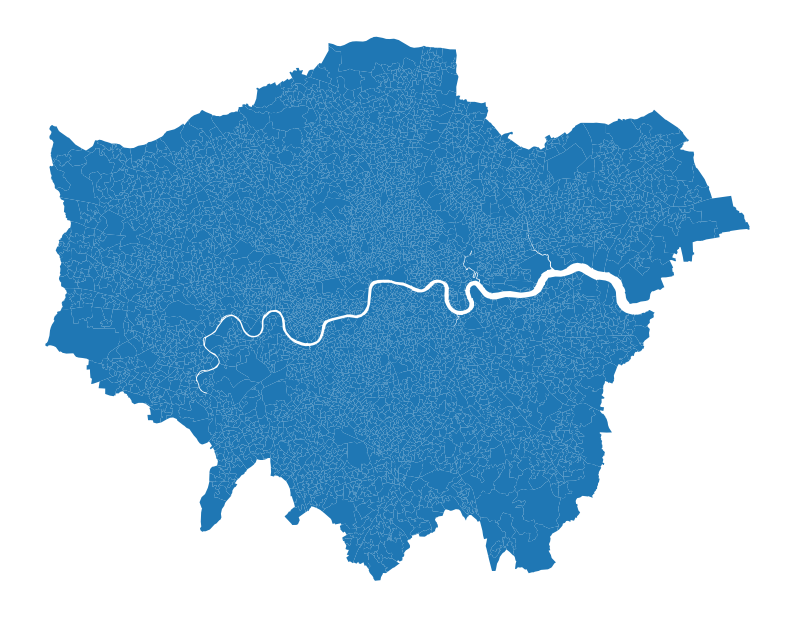

In [106]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
lsoa.plot(ax=ax)
ax.set_axis_off()
plt.show()

In [107]:
caz = gpd.read_file('Data/GIS/CAZ/Central_Activities_Zone.gpkg')
print("Original CRS:", caz.crs)

caz = caz.to_crs(epsg=27700)
print("New CRS:", caz.crs)

Original CRS: PROJCS["unnamed",GEOGCS["Airy 1830",DATUM["unknown",SPHEROID["airy",6377563.396,299.324975315035],EXTENSION["PROJ4_GRIDS","Q:\Temp\yw\ostn02-ntv2-data\OSTN02_NTv2.gsb"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
New CRS: EPSG:27700


<Axes: >

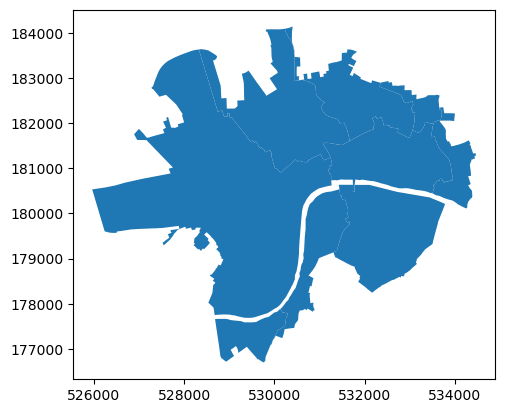

In [108]:
caz.plot()

In [109]:
boros = gpd.read_file('Data/GIS/Borough/London_Borough_Excluding_MHW.shp')
print("Original CRS:", boros.crs)

boros = boros.to_crs(epsg=27700)
print("New CRS:", boros.crs)

Original CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
New CRS: EPSG:27700


In [110]:
inner_boros = boros[boros['ONS_INNER'] == 'T']

<Axes: >

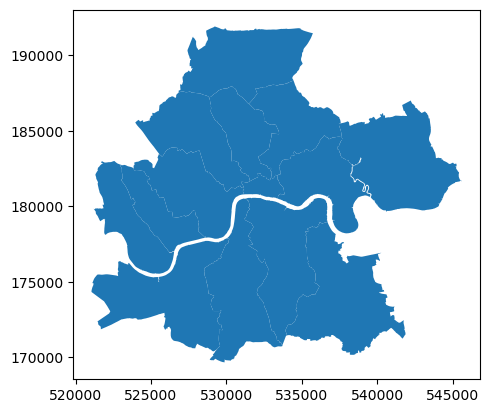

In [111]:
inner_boros.plot()

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_12873/1706424299.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


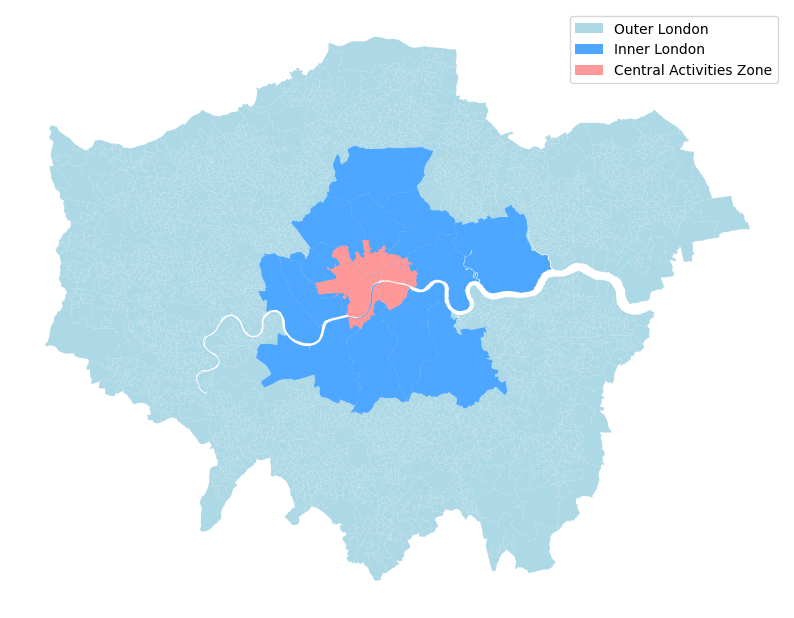

In [112]:
caz["label"] = "Central Activities Zone"
inner_boros["label"] = "Inner London"
lsoa["label"] = "Outer London"

fig, ax = plt.subplots(figsize=(10, 10))

lsoa.plot(ax=ax, color='#add8e6', linewidth=0, label='Outer London')
inner_boros.plot(ax=ax, color='#4da6ff', linewidth=0, label='Inner London')
caz.plot(ax=ax, color='#ff9999', linewidth=0, edgecolor='black', label='Central Activities Zone')

ax.axis('off')
ax.legend()

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#add8e6', label='Outer London'),
    Patch(facecolor='#4da6ff', label='Inner London'),
    Patch(facecolor='#ff9999', label='Central Activities Zone')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.show()

In [113]:
from shapely.geometry import Point

lsoa = lsoa.to_crs(caz.crs)
lsoa_centroids = lsoa.geometry.centroid

# Combine all CAZ polygons into a single geometry
caz_union = caz.unary_union
inner_boros_union = inner_boros.unary_union

# Create the new boolean column: 1 if centroid is within CAZ, else 0
lsoa["caz"] = lsoa.geometry.intersects(caz_union).astype(int)
lsoa["inner"] = lsoa.geometry.intersects(inner_boros_union).astype(int)

/tmp/ipykernel_12873/635959943.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  caz_union = caz.unary_union
/tmp/ipykernel_12873/635959943.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  inner_boros_union = inner_boros.unary_union


In [114]:
# Tier 1: CAZ only
tier1 = lsoa[(lsoa['inner'] == 1) & (lsoa['caz'] == 1)]
print("Tier 1 count:", len(tier1))
tier1 = tier1.copy()
tier1['tier'] = 'Tier 1'

# Tier 2: Inner only (but not CAZ)
tier2 = lsoa[(lsoa['inner'] == 1) & (lsoa['caz'] == 0)]
print("Tier 2 count:", len(tier2))
tier2 = tier2.copy()
tier2['tier'] = 'Tier 2'

# Tier 3: Neither
tier3 = lsoa[(lsoa['inner'] == 0) & (lsoa['caz'] == 0)]
print("Tier 3 count:", len(tier3))
tier3 = tier3.copy()
tier3['tier'] = 'Tier 3'

Tier 1 count: 210
Tier 2 count: 1822
Tier 3 count: 2803


In [115]:
stations = gpd.read_file('Data/GIS/TfL/tfl_stations.json')
stations = stations.to_crs(epsg = 27700)

In [116]:
import re

station_names = {row.id: row['name'] for i, row in stations.iterrows()}

for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])
cleaned_name_map = stations.set_index('id')['name'].to_dict()

In [117]:
stations

,id,name,nlc_id,lines,cartography,altmodeid,alt_id,altmodeid2,zone,geometry
0,940GZZLUACT,Acton Town,0500,"[ { ""name"": ""District"" }, { ""name"": ""Piccadill...","{ ""labelX"": 30 }",None,1,None,3,POINT (519483.347 179591.968)
1,940GZZLUACY,Archway,0508,"[ { ""name"": ""Northern"", ""nightopened"": 2016 } ]","{ ""labelX"": -30 }",None,8,None,2/3,POINT (529380.63 186814.054)
2,940GZZLUADE,Aldgate East,0503,"[ { ""name"": ""District"" }, { ""name"": ""Hammersmi...","{ ""labelX"": 30 }",None,3,None,1,POINT (533885.038 181342.159)
3,940GZZLUAGL,Angel,0507,"[ { ""name"": ""Northern"" }, { ""name"": ""Crossrail...","{ ""labelX"": 1, ""labelY"": -35 }",None,7,None,1,POINT (531460.461 183134.266)
4,940GZZLUALD,Aldgate,0502,"[ { ""name"": ""Circle"" }, { ""name"": ""Metropolita...","{ ""labelX"": 25, ""labelY"": 20 }",None,2,None,1,POINT (533621.756 181218.291)
...,...,...,...,...,...,...,...,...,...,...
524,910GWNSTDPK,Wanstead Park,7408,"[ { ""name"": ""London Overground"", ""opened"": 200...","{ ""labelX"": 1, ""labelY"": -45 }",None,None,None,3,POINT (540586.481 185590.993)
525,910GWOLWXR,Woolwich,None,"[ { ""name"": ""Crossrail"", ""opened"": 2018 } ]","{ ""labelX"": 25, ""labelY"": -20 }",None,None,None,4,POINT (543858.406 179015.443)
526,910GWRCSTRP,Worcester Park,5579,"[ { ""name"": ""National Rail"", ""opened"": 2030 },...","{ ""labelX"": 30 }",None,WCP,None,4,POINT (522232.396 166165.91)
527,910G950,Canary Wharf,None,"[ { ""name"": ""Crossrail"", ""opened"": 2018 } ]","{ ""labelX"": 30 }",None,None,None,2,POINT (537686.851 180457.484)


In [118]:
import ast

# Safely parse string representations into actual Python lists
stations["parsed_lines"] = stations["lines"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

unique_names = set()

for lines in stations["parsed_lines"]:
    if isinstance(lines, list):
        for item in lines:
            if isinstance(item, dict) and "name" in item:
                unique_names.add(item["name"])

print(sorted(unique_names))

['Bakerloo', 'Central', 'Circle', 'Crossrail', 'Crossrail 2', 'DLR', 'District', 'East London', 'Emirates Air Line', 'Hammersmith & City', 'Jubilee', 'London Overground', 'Metropolitan', 'National Rail', 'Northern', 'Piccadilly', 'TfL Rail', 'Tramlink', 'Victoria', 'Waterloo & City']


In [119]:
# Define filter function
def has_crossrail(lines):
    if isinstance(lines, list):
        return any(d.get("name") == "Crossrail" for d in lines)
    return False

crossrail_stations = stations[stations['parsed_lines'].apply(has_crossrail)]
print(crossrail_stations[['name', 'lines']])

                         name  \
107       Heathrow Terminal 4   
108       Heathrow Terminal 5   
109  Heathrow Terminals 2 & 3   
363                Abbey Wood   
365           Acton Main Line   
372                   Burnham   
373               Bond Street   
380                 Brentwood   
386            Chadwell Heath   
401              Custom House   
405           Ealing Broadway   
414                Farringdon   
416               Forest Gate   
418                Gidea Park   
419                 Goodmayes   
427                   Hanwell   
428        Hayes & Harlington   
438               Harold Wood   
440                    Ilford   
441                      Iver   
447                   Langley   
449          Liverpool Street   
450          Liverpool Street   
454                Manor Park   
455                Maidenhead   
457                  Maryland   
465                Paddington   
466                Paddington   
473                   Reading   
474       

In [120]:
# Figure out whether the two "Liverpool Stations" are duplicate entries
liverpool_stations = stations[stations["name"] == "Liverpool Street"]
print(liverpool_stations)

# Check if geometries are identical
geometries_equal = liverpool_stations.geometry.iloc[0].equals(liverpool_stations.geometry.iloc[1])
print("\nSame geometry:", geometries_equal)

              id              name nlc_id  \
138  940GZZLULVT  Liverpool Street   0634   
449    910GLIVST  Liverpool Street   6965   
450  910GLIVSTLL  Liverpool Street   None   

                                                 lines  \
138  [ { "name": "Central", "nightopened": 2016 }, ...   
449  [ { "name": "London Overground", "opened": 201...   
450        [ { "name": "Crossrail", "opened": 2018 } ]   

                                           cartography altmodeid alt_id  \
138                      { "labelX": 1, "labelY": 45 }      None    157   
449  { "labelX": 1, "labelY": 45, "display_name": "...      None    LST   
450  { "labelX": -1, "labelY": -45, "display_name":...      None   None   

    altmodeid2 zone                       geometry  \
138       None    1  POINT (533092.226 181560.876)   
449       None    1   POINT (533264.24 181654.408)   
450       None    1   POINT (533021.42 181648.039)   

                                          parsed_lines  
138  [{'nam

In [121]:
crossrail_stations = crossrail_stations.drop(index=449)
print(crossrail_stations[['name', 'lines']])

                         name  \
107       Heathrow Terminal 4   
108       Heathrow Terminal 5   
109  Heathrow Terminals 2 & 3   
363                Abbey Wood   
365           Acton Main Line   
372                   Burnham   
373               Bond Street   
380                 Brentwood   
386            Chadwell Heath   
401              Custom House   
405           Ealing Broadway   
414                Farringdon   
416               Forest Gate   
418                Gidea Park   
419                 Goodmayes   
427                   Hanwell   
428        Hayes & Harlington   
438               Harold Wood   
440                    Ilford   
441                      Iver   
447                   Langley   
450          Liverpool Street   
454                Manor Park   
455                Maidenhead   
457                  Maryland   
465                Paddington   
466                Paddington   
473                   Reading   
474                   Romford   
480       

In [122]:
# Figure out whether the two "Paddington Stations" are duplicate entries
paddington_stations = stations[stations["name"] == "Paddington"]
print(paddington_stations)

# Check if geometries are identical
geometries_equal = paddington_stations.geometry.iloc[0].equals(paddington_stations.geometry.iloc[1])
print("\nSame geometry:", geometries_equal)

              id        name  nlc_id  \
171  940GZZLUPAC  Paddington    0670   
172  940GZZLUPAH  Paddington    3087   
465   910GPADTLL  Paddington    None   
466   910GPADTON  Paddington  308700   

                                                 lines  \
171  [ { "name": "Bakerloo" }, { "name": "District"...   
172  [ { "name": "Hammersmith & City" }, { "name": ...   
465        [ { "name": "Crossrail", "opened": 2018 } ]   
466  [ { "name": "Crossrail", "opened": 2018, "clos...   

                                           cartography altmodeid alt_id  \
171     { "labelX": 30, "display_name": "Paddington" }      None   None   
172  { "labelX": 1, "labelY": -30, "display_name": ...      None    193   
465  { "labelX": -25, "labelY": 20, "display_name":...      None   None   
466  { "labelX": -25, "labelY": 20, "display_name":...      None    PAD   

    altmodeid2 zone                       geometry  \
171       None    1  POINT (526763.197 181249.357)   
172       None    1  POI

In [123]:
crossrail_stations = crossrail_stations.drop(index=465)
print(crossrail_stations[['name', 'lines']])

                         name  \
107       Heathrow Terminal 4   
108       Heathrow Terminal 5   
109  Heathrow Terminals 2 & 3   
363                Abbey Wood   
365           Acton Main Line   
372                   Burnham   
373               Bond Street   
380                 Brentwood   
386            Chadwell Heath   
401              Custom House   
405           Ealing Broadway   
414                Farringdon   
416               Forest Gate   
418                Gidea Park   
419                 Goodmayes   
427                   Hanwell   
428        Hayes & Harlington   
438               Harold Wood   
440                    Ilford   
441                      Iver   
447                   Langley   
450          Liverpool Street   
454                Manor Park   
455                Maidenhead   
457                  Maryland   
466                Paddington   
473                   Reading   
474                   Romford   
480                 Shenfield   
485       

In [124]:
lsoa_union = lsoa.unary_union
crossrail_stations = crossrail_stations[crossrail_stations.geometry.within(lsoa_union)].copy()

/tmp/ipykernel_12873/3970372433.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lsoa_union = lsoa.unary_union


In [125]:
crossrail_stations["caz"] = crossrail_stations.geometry.intersects(caz_union).astype(int)
crossrail_stations["inner"] = crossrail_stations.geometry.intersects(inner_boros_union).astype(int)

In [126]:
import glob

In [127]:
import glob
import pandas as pd

file_paths_hts = glob.glob('Data/BRES/ABI/ABI_*.csv')  # updated pattern
hts_data_frames = {}
failed_files = {}

for file_path in file_paths_hts:
    # Extract the year from filenames like 'KI_2009.csv'
    year = file_path.rsplit("/", 1)[-1].replace("KI_", "").replace(".csv", "")
    
    try:
        # Read with comma separator
        df = pd.read_csv(file_path, sep=',', engine='python', on_bad_lines='skip')
        
        # Drop completely empty columns
        df = df.dropna(axis=1, how='all')

        # Convert numerics where possible
        df = df.apply(pd.to_numeric, errors='ignore')

        # Report and drop rows with NaNs
        n_with_nan = df.isna().any(axis=1).sum()
        print(f"{year}: {n_with_nan} rows with ≥1 NaN")
        original_rows = len(df)
        df = df.dropna()
        dropped = original_rows - len(df)
        print(f"{year}: {dropped} rows dropped, {len(df)} rows kept")

        hts_data_frames[year] = df

    except Exception as e:
        failed_files[year] = str(e)

print("\n Years loaded:", sorted(hts_data_frames.keys()))
print("Years failed:", sorted(failed_files.keys()))


/tmp/ipykernel_12873/3920159536.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


ABI_2008: 0 rows with ≥1 NaN
ABI_2008: 0 rows dropped, 4766 rows kept


/tmp/ipykernel_12873/3920159536.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


ABI_2003: 0 rows with ≥1 NaN
ABI_2003: 0 rows dropped, 4766 rows kept


/tmp/ipykernel_12873/3920159536.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


ABI_2005: 0 rows with ≥1 NaN
ABI_2005: 0 rows dropped, 4766 rows kept


/tmp/ipykernel_12873/3920159536.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


ABI_2004: 0 rows with ≥1 NaN
ABI_2004: 0 rows dropped, 4766 rows kept


/tmp/ipykernel_12873/3920159536.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


ABI_2006: 0 rows with ≥1 NaN
ABI_2006: 0 rows dropped, 4766 rows kept
ABI_2007: 0 rows with ≥1 NaN
ABI_2007: 0 rows dropped, 4766 rows kept

 Years loaded: ['ABI_2003', 'ABI_2004', 'ABI_2005', 'ABI_2006', 'ABI_2007', 'ABI_2008']
Years failed: []


/tmp/ipykernel_12873/3920159536.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [128]:
for year, df in hts_data_frames.items():
    year_str = year[-4:]  # Get last 4 characters
    year_int = int(year_str)
    geo_key = 'LSOA01CD' if year_int <= 2014 else 'LSOA11CD'

    numeric_cols = [
        col for col in df.columns
        if col not in [geo_key, 'inner_outer'] 
        and pd.api.types.is_numeric_dtype(df[col])
        and not col.startswith('Unnamed')
    ]

    df['total'] = df[numeric_cols].sum(axis=1)
    hts_data_frames[year] = df

In [129]:
hts_2003 = hts_data_frames["ABI_2003"]
hts_2004 = hts_data_frames["ABI_2004"]
hts_2005 = hts_data_frames["ABI_2005"]
hts_2006 = hts_data_frames["ABI_2006"]
hts_2007 = hts_data_frames["ABI_2007"]
hts_2008 = hts_data_frames["ABI_2008"]

In [130]:
from IPython.display import display

for year, df in sorted(hts_data_frames.items()):
    print(f"\n===== {year} =====")
    print("Shape:", df.shape)
    print("Dtypes:\n", df.dtypes, "\n")
    print("Head:")
    display(df.head())


===== ABI_2003 =====
Shape: (4766, 21)
Dtypes:
 2001 super output areas - lower layer                                                                  object
mnemonic                                                                                               object
22 : Publishing, printing and reproduction of recorded media                                            int64
24 : Manufacture of chemicals and chemical products                                                     int64
30 : Manufacture of office machinery and computers                                                      int64
32 : Manufacture of radio, television and communication equipment and apparatus                         int64
33 : Manufacture of medical, precision and optical instruments, watches and clocks                      int64
50 : Sale, maintenance and repair of motor vehicles and motorcycles; retail sale of automotive fuel     int64
51 : Wholesale trade and commission trade, except of motor vehicles and

,2001 super output areas - lower layer,mnemonic,"22 : Publishing, printing and reproduction of recorded media",24 : Manufacture of chemicals and chemical products,30 : Manufacture of office machinery and computers,"32 : Manufacture of radio, television and communication equipment and apparatus","33 : Manufacture of medical, precision and optical instruments, watches and clocks","50 : Sale, maintenance and repair of motor vehicles and motorcycles; retail sale of automotive fuel","51 : Wholesale trade and commission trade, except of motor vehicles and motorcycles",64 : Post and telecommunications,...,"66 : Insurance and pension funding, except compulsory social security",67 : Activities auxiliary to financial intermediation,72 : Computer and related activites,73 : Research and development,74 : Other business activities,75 : Public administration and defence; compulsory social security,80 : Education,85 : Health and social work,"92 : Recreational, cultural and sporting activities",total
0,Camden 001A,E01000907,0,0,0,0,0,0,0,0,...,0,0,0,0,10,0,0,0,10,20
1,Camden 001B,E01000908,5,0,0,0,0,0,0,0,...,0,0,10,0,5,0,100,20,25,165
2,Camden 001C,E01000909,0,10,0,0,0,0,10,0,...,0,0,5,0,40,0,0,25,30,120
3,Camden 001D,E01000912,10,0,0,0,0,5,25,0,...,0,5,5,0,80,0,150,225,50,555
4,Camden 001E,E01000913,5,0,0,0,0,5,20,0,...,5,0,50,0,80,0,35,125,100,430



===== ABI_2004 =====
Shape: (4766, 21)
Dtypes:
 2001 super output areas - lower layer                                                                  object
mnemonic                                                                                               object
22 : Publishing, printing and reproduction of recorded media                                            int64
24 : Manufacture of chemicals and chemical products                                                     int64
30 : Manufacture of office machinery and computers                                                      int64
32 : Manufacture of radio, television and communication equipment and apparatus                         int64
33 : Manufacture of medical, precision and optical instruments, watches and clocks                      int64
50 : Sale, maintenance and repair of motor vehicles and motorcycles; retail sale of automotive fuel     int64
51 : Wholesale trade and commission trade, except of motor vehicles and

,2001 super output areas - lower layer,mnemonic,"22 : Publishing, printing and reproduction of recorded media",24 : Manufacture of chemicals and chemical products,30 : Manufacture of office machinery and computers,"32 : Manufacture of radio, television and communication equipment and apparatus","33 : Manufacture of medical, precision and optical instruments, watches and clocks","50 : Sale, maintenance and repair of motor vehicles and motorcycles; retail sale of automotive fuel","51 : Wholesale trade and commission trade, except of motor vehicles and motorcycles",64 : Post and telecommunications,...,"66 : Insurance and pension funding, except compulsory social security",67 : Activities auxiliary to financial intermediation,72 : Computer and related activites,73 : Research and development,74 : Other business activities,75 : Public administration and defence; compulsory social security,80 : Education,85 : Health and social work,"92 : Recreational, cultural and sporting activities",total
0,Camden 001A,E01000907,0,0,0,0,0,0,0,0,...,0,0,0,0,10,0,0,0,15,25
1,Camden 001B,E01000908,5,0,0,0,0,0,0,0,...,0,0,10,0,10,0,125,20,40,210
2,Camden 001C,E01000909,0,10,0,0,0,0,5,0,...,0,5,5,0,60,0,0,5,30,120
3,Camden 001D,E01000912,0,0,0,0,0,5,20,30,...,0,0,10,0,35,0,200,100,75,475
4,Camden 001E,E01000913,5,0,0,0,0,0,15,0,...,0,0,40,0,50,0,20,125,150,410



===== ABI_2005 =====
Shape: (4766, 21)
Dtypes:
 2001 super output areas - lower layer                                                                  object
mnemonic                                                                                               object
22 : Publishing, printing and reproduction of recorded media                                            int64
24 : Manufacture of chemicals and chemical products                                                     int64
30 : Manufacture of office machinery and computers                                                      int64
32 : Manufacture of radio, television and communication equipment and apparatus                         int64
33 : Manufacture of medical, precision and optical instruments, watches and clocks                      int64
50 : Sale, maintenance and repair of motor vehicles and motorcycles; retail sale of automotive fuel     int64
51 : Wholesale trade and commission trade, except of motor vehicles and

,2001 super output areas - lower layer,mnemonic,"22 : Publishing, printing and reproduction of recorded media",24 : Manufacture of chemicals and chemical products,30 : Manufacture of office machinery and computers,"32 : Manufacture of radio, television and communication equipment and apparatus","33 : Manufacture of medical, precision and optical instruments, watches and clocks","50 : Sale, maintenance and repair of motor vehicles and motorcycles; retail sale of automotive fuel","51 : Wholesale trade and commission trade, except of motor vehicles and motorcycles",64 : Post and telecommunications,...,"66 : Insurance and pension funding, except compulsory social security",67 : Activities auxiliary to financial intermediation,72 : Computer and related activites,73 : Research and development,74 : Other business activities,75 : Public administration and defence; compulsory social security,80 : Education,85 : Health and social work,"92 : Recreational, cultural and sporting activities",total
0,Camden 001A,E01000907,0,0,0,0,0,0,0,0,...,0,0,0,0,10,0,0,0,15,25
1,Camden 001B,E01000908,5,0,0,0,0,0,0,0,...,0,0,10,0,10,0,75,25,20,145
2,Camden 001C,E01000909,0,10,0,0,0,0,5,0,...,0,5,5,0,70,0,0,10,30,135
3,Camden 001D,E01000912,0,0,0,0,0,10,20,40,...,0,0,10,0,50,0,200,175,125,630
4,Camden 001E,E01000913,5,0,0,0,0,0,15,0,...,0,0,35,0,60,0,20,40,100,280



===== ABI_2006 =====
Shape: (4766, 21)
Dtypes:
 2001 super output areas - lower layer                                                                  object
mnemonic                                                                                               object
22 : Publishing, printing and reproduction of recorded media                                            int64
24 : Manufacture of chemicals and chemical products                                                     int64
30 : Manufacture of office machinery and computers                                                      int64
32 : Manufacture of radio, television and communication equipment and apparatus                         int64
33 : Manufacture of medical, precision and optical instruments, watches and clocks                      int64
50 : Sale, maintenance and repair of motor vehicles and motorcycles; retail sale of automotive fuel     int64
51 : Wholesale trade and commission trade, except of motor vehicles and

,2001 super output areas - lower layer,mnemonic,"22 : Publishing, printing and reproduction of recorded media",24 : Manufacture of chemicals and chemical products,30 : Manufacture of office machinery and computers,"32 : Manufacture of radio, television and communication equipment and apparatus","33 : Manufacture of medical, precision and optical instruments, watches and clocks","50 : Sale, maintenance and repair of motor vehicles and motorcycles; retail sale of automotive fuel","51 : Wholesale trade and commission trade, except of motor vehicles and motorcycles",64 : Post and telecommunications,...,"66 : Insurance and pension funding, except compulsory social security",67 : Activities auxiliary to financial intermediation,72 : Computer and related activites,73 : Research and development,74 : Other business activities,75 : Public administration and defence; compulsory social security,80 : Education,85 : Health and social work,"92 : Recreational, cultural and sporting activities",total
0,Camden 001A,E01000907,0,0,0,0,0,0,0,0,...,0,0,5,0,10,0,0,10,15,40
1,Camden 001B,E01000908,5,0,0,0,0,0,0,0,...,0,0,10,0,10,0,45,10,15,95
2,Camden 001C,E01000909,0,10,0,0,0,0,5,0,...,0,0,10,0,60,0,0,15,25,125
3,Camden 001D,E01000912,0,0,0,0,0,10,10,35,...,0,0,20,0,60,200,20,250,125,730
4,Camden 001E,E01000913,20,0,0,0,0,0,15,0,...,0,0,40,0,70,0,30,30,150,365



===== ABI_2007 =====
Shape: (4766, 21)
Dtypes:
 2001 super output areas - lower layer                                                                  object
mnemonic                                                                                               object
22 : Publishing, printing and reproduction of recorded media                                            int64
24 : Manufacture of chemicals and chemical products                                                     int64
30 : Manufacture of office machinery and computers                                                      int64
32 : Manufacture of radio, television and communication equipment and apparatus                         int64
33 : Manufacture of medical, precision and optical instruments, watches and clocks                      int64
50 : Sale, maintenance and repair of motor vehicles and motorcycles; retail sale of automotive fuel     int64
51 : Wholesale trade and commission trade, except of motor vehicles and

,2001 super output areas - lower layer,mnemonic,"22 : Publishing, printing and reproduction of recorded media",24 : Manufacture of chemicals and chemical products,30 : Manufacture of office machinery and computers,"32 : Manufacture of radio, television and communication equipment and apparatus","33 : Manufacture of medical, precision and optical instruments, watches and clocks","50 : Sale, maintenance and repair of motor vehicles and motorcycles; retail sale of automotive fuel","51 : Wholesale trade and commission trade, except of motor vehicles and motorcycles",64 : Post and telecommunications,...,"66 : Insurance and pension funding, except compulsory social security",67 : Activities auxiliary to financial intermediation,72 : Computer and related activites,73 : Research and development,74 : Other business activities,75 : Public administration and defence; compulsory social security,80 : Education,85 : Health and social work,"92 : Recreational, cultural and sporting activities",total
0,Camden 001A,E01000907,0,0,0,0,0,0,0,0,...,0,0,5,0,10,0,0,10,20,45
1,Camden 001B,E01000908,5,0,0,0,0,0,0,0,...,0,0,15,0,10,0,45,10,15,100
2,Camden 001C,E01000909,5,10,0,0,0,0,5,0,...,0,0,10,0,60,0,0,15,20,125
3,Camden 001D,E01000912,0,0,0,0,0,10,10,30,...,0,0,10,0,50,0,350,250,45,755
4,Camden 001E,E01000913,15,0,0,0,0,0,15,0,...,0,0,35,0,80,0,25,30,100,305



===== ABI_2008 =====
Shape: (4766, 21)
Dtypes:
 2001 super output areas - lower layer                                                                  object
mnemonic                                                                                               object
22 : Publishing, printing and reproduction of recorded media                                            int64
24 : Manufacture of chemicals and chemical products                                                     int64
30 : Manufacture of office machinery and computers                                                      int64
32 : Manufacture of radio, television and communication equipment and apparatus                         int64
33 : Manufacture of medical, precision and optical instruments, watches and clocks                      int64
50 : Sale, maintenance and repair of motor vehicles and motorcycles; retail sale of automotive fuel     int64
51 : Wholesale trade and commission trade, except of motor vehicles and

,2001 super output areas - lower layer,mnemonic,"22 : Publishing, printing and reproduction of recorded media",24 : Manufacture of chemicals and chemical products,30 : Manufacture of office machinery and computers,"32 : Manufacture of radio, television and communication equipment and apparatus","33 : Manufacture of medical, precision and optical instruments, watches and clocks","50 : Sale, maintenance and repair of motor vehicles and motorcycles; retail sale of automotive fuel","51 : Wholesale trade and commission trade, except of motor vehicles and motorcycles",64 : Post and telecommunications,...,"66 : Insurance and pension funding, except compulsory social security",67 : Activities auxiliary to financial intermediation,72 : Computer and related activites,73 : Research and development,74 : Other business activities,75 : Public administration and defence; compulsory social security,80 : Education,85 : Health and social work,"92 : Recreational, cultural and sporting activities",total
0,Camden 001A,E01000907,0,0,0,0,0,0,0,0,...,0,0,5,0,10,0,0,0,15,30
1,Camden 001B,E01000908,5,0,0,0,0,0,0,0,...,0,0,15,0,15,0,20,35,15,105
2,Camden 001C,E01000909,0,0,0,0,0,0,5,0,...,0,0,5,0,60,0,5,10,25,110
3,Camden 001D,E01000912,0,0,0,0,0,10,50,50,...,0,0,10,0,60,0,350,100,75,705
4,Camden 001E,E01000913,15,0,0,0,0,0,30,0,...,0,0,40,0,90,0,30,25,75,310


In [131]:
years_1 = ['ABI_2003', 'ABI_2004', 'ABI_2005', 'ABI_2006', 'ABI_2007', 'ABI_2008']

for year in years_1:
    df_1 = hts_data_frames[f'hts_{year}' if f'hts_{year}' in hts_data_frames else year]
    # Keep only relevant columns and rename
    df_1 = df_1[['mnemonic', 'total']].rename(columns={'mnemonic': '01cd'})
    # Save back
    hts_data_frames[year] = df_1

In [132]:
hts_2003 = hts_data_frames["ABI_2003"]
hts_2004 = hts_data_frames["ABI_2004"]
hts_2005 = hts_data_frames["ABI_2005"]
hts_2006 = hts_data_frames["ABI_2006"]
hts_2007 = hts_data_frames["ABI_2007"]
hts_2008 = hts_data_frames["ABI_2008"]

In [133]:
from IPython.display import display

for year, df in sorted(hts_data_frames.items()):
    print(f"\n===== {year} =====")
    print("Shape:", df.shape)
    print("Dtypes:\n", df.dtypes, "\n")
    print("Head:")
    display(df.head())


===== ABI_2003 =====
Shape: (4766, 2)
Dtypes:
 01cd     object
total     int64
dtype: object 

Head:


,01cd,total
0,E01000907,20
1,E01000908,165
2,E01000909,120
3,E01000912,555
4,E01000913,430



===== ABI_2004 =====
Shape: (4766, 2)
Dtypes:
 01cd     object
total     int64
dtype: object 

Head:


,01cd,total
0,E01000907,25
1,E01000908,210
2,E01000909,120
3,E01000912,475
4,E01000913,410



===== ABI_2005 =====
Shape: (4766, 2)
Dtypes:
 01cd     object
total     int64
dtype: object 

Head:


,01cd,total
0,E01000907,25
1,E01000908,145
2,E01000909,135
3,E01000912,630
4,E01000913,280



===== ABI_2006 =====
Shape: (4766, 2)
Dtypes:
 01cd     object
total     int64
dtype: object 

Head:


,01cd,total
0,E01000907,40
1,E01000908,95
2,E01000909,125
3,E01000912,730
4,E01000913,365



===== ABI_2007 =====
Shape: (4766, 2)
Dtypes:
 01cd     object
total     int64
dtype: object 

Head:


,01cd,total
0,E01000907,45
1,E01000908,100
2,E01000909,125
3,E01000912,755
4,E01000913,305



===== ABI_2008 =====
Shape: (4766, 2)
Dtypes:
 01cd     object
total     int64
dtype: object 

Head:


,01cd,total
0,E01000907,30
1,E01000908,105
2,E01000909,110
3,E01000912,705
4,E01000913,310


In [134]:
lookup_path = 'Data/GIS/Lookup/Lower_Layer_Super_Output_Area_(2001)_to_Lower_Layer_Super_Output_Area_(2011)_to_Local_Authority_District_(2011)_Lookup_in_England_and_Wales.shp'
lookup = gpd.read_file(lookup_path)
lookup = lookup.to_crs(epsg=27700)

print("New CRS:", lookup.crs)

New CRS: EPSG:27700


In [135]:
target_years = ['ABI_2003', 'ABI_2004', 'ABI_2005', 'ABI_2006', 'ABI_2007', 'ABI_2008']

for year in target_years:
    print(f"\nProcessing {year}...")

    df = hts_data_frames[year]

    # Merge with lookup
    merged = df.merge(
        lookup[['LSOA01CD', 'LSOA11CD']],
        left_on='01cd',
        right_on='LSOA01CD',
        how='left'
    )

    # Handle unmatched
    n_unmatched = merged['LSOA11CD'].isna().sum()
    print(f"{n_unmatched} unmatched codes in {year}")

    # Check for duplicates
    relevant_duplicates = merged.groupby('LSOA11CD').filter(lambda x: len(x) > 1)
    print(f"{relevant_duplicates['LSOA11CD'].nunique()} new codes appear more than once")

    # Drop unmatched rows
    merged = merged[~merged['LSOA11CD'].isna()].copy()

    # Replace 'mnemonic' with new code
    merged['01cd'] = merged['LSOA11CD']

    # Drop extra columns
    merged = merged.drop(columns=['LSOA01CD', 'LSOA11CD'])

    # Group by new code and average
    cleaned = (
        merged
        .groupby('01cd', as_index=False)[['total']]
        .mean()
        .rename(columns={'01cd': '11cd'})
    )

    # Store cleaned data
    hts_data_frames[year] = cleaned

print("\n All years processed with LSOA11CD as the geographic identifier.")


Processing ABI_2003...
1 unmatched codes in ABI_2003
15 new codes appear more than once

Processing ABI_2004...
1 unmatched codes in ABI_2004
15 new codes appear more than once

Processing ABI_2005...
1 unmatched codes in ABI_2005
15 new codes appear more than once

Processing ABI_2006...
1 unmatched codes in ABI_2006
15 new codes appear more than once

Processing ABI_2007...
1 unmatched codes in ABI_2007
15 new codes appear more than once

Processing ABI_2008...
1 unmatched codes in ABI_2008
15 new codes appear more than once

 All years processed with LSOA11CD as the geographic identifier.


In [136]:
for year, df in sorted(hts_data_frames.items()):
    print(f"\n===== {year} =====")
    print("Shape:", df.shape)
    print("Dtypes:\n", df.dtypes, "\n")
    print("Head:")
    display(df.head())


===== ABI_2003 =====
Shape: (4834, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000001,7205.0
1,E01000002,13205.0
2,E01000003,910.0
3,E01000005,18470.0
4,E01000006,5.0



===== ABI_2004 =====
Shape: (4834, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000001,5945.0
1,E01000002,12880.0
2,E01000003,960.0
3,E01000005,14325.0
4,E01000006,5.0



===== ABI_2005 =====
Shape: (4834, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000001,6485.0
1,E01000002,15750.0
2,E01000003,980.0
3,E01000005,15875.0
4,E01000006,5.0



===== ABI_2006 =====
Shape: (4834, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000001,7335.0
1,E01000002,17890.0
2,E01000003,1125.0
3,E01000005,14900.0
4,E01000006,5.0



===== ABI_2007 =====
Shape: (4834, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000001,7160.0
1,E01000002,21040.0
2,E01000003,905.0
3,E01000005,11085.0
4,E01000006,10.0



===== ABI_2008 =====
Shape: (4834, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000001,8650.0
1,E01000002,21285.0
2,E01000003,755.0
3,E01000005,15390.0
4,E01000006,30.0


In [137]:
renamed_yearly_dfs = []

# Loop over each year
for year, df in hts_data_frames.items():
    # Pad the year to 2-digit format (e.g. "09", "14", "23")
    suffix = year[-2:]
    
    df_renamed = df.rename(columns={
        'total': f'count_{suffix}'
    })

    df_renamed = df_renamed.set_index('11cd')

    renamed_yearly_dfs.append(df_renamed)

from functools import reduce

lsoa_ki = reduce(lambda left, right: left.join(right, how='outer'), renamed_yearly_dfs)
lsoa_ki = lsoa_ki.reset_index()

print(lsoa_ki.shape)
print(lsoa_ki.columns)

(4834, 7)
Index(['11cd', 'count_08', 'count_03', 'count_05', 'count_04', 'count_06',
       'count_07'],
      dtype='object')


In [138]:
lsoa_ki = lsoa_ki.rename(columns={'11cd': 'LSOA11CD'})

In [139]:
lsoa_ki = lsoa.merge(
    lsoa_ki,
    on='LSOA11CD',
    how='right',
    suffixes=('', '_right')
)

unmatched = lsoa_ki[lsoa_ki['geometry'].isna()]
print(f"Unmatched LSOA11CDs from lsoa_ki not found in lsoa: {len(unmatched)}")
if not unmatched.empty:
    print("Example unmatched LSOA11CDs:")
    print(unmatched['LSOA11CD'].head())


ki_columns = [col for col in lsoa_ki.columns if col.startswith('count_')]
ref_columns = ['LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'caz', 'inner', 'geometry']

# Combine and keep only these columns in final output
lsoa_ki = lsoa_ki[ki_columns + ref_columns]

print(f"\nFinal merged GeoDataFrame shape: {lsoa_ki.shape}")

Unmatched LSOA11CDs from lsoa_ki not found in lsoa: 0

Final merged GeoDataFrame shape: (4834, 14)


In [140]:
count_cols = [col for col in lsoa_ki.columns if col.startswith("count_")]

for count_col in count_cols:
    year_suffix = count_col.split("_")[1]
    share_col = f"share_{year_suffix}"
    
    total_sum = lsoa_ki[count_col].sum()
    lsoa_ki[share_col] = lsoa_ki[count_col] / total_sum

In [141]:
lsoa_ki

,count_08,count_03,count_05,count_04,count_06,count_07,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,caz,inner,geometry,share_08,share_03,share_05,share_04,share_06,share_07
0,8650.0,7205.0,6485.0,5945.0,7335.0,7160.0,City of London 001A,E02000001,City of London 001,E09000001,City of London,1,1,"POLYGON ((532105.092 182011.23, 532162.491 181...",0.002585,0.002352,0.002026,0.001911,0.002282,0.002152
1,21285.0,13205.0,15750.0,12880.0,17890.0,21040.0,City of London 001B,E02000001,City of London 001,E09000001,City of London,1,1,"POLYGON ((532746.813 181786.891, 532671.688 18...",0.006360,0.004310,0.004920,0.004141,0.005566,0.006324
2,755.0,910.0,980.0,960.0,1125.0,905.0,City of London 001C,E02000001,City of London 001,E09000001,City of London,1,1,"POLYGON ((532135.145 182198.119, 532158.25 182...",0.000226,0.000297,0.000306,0.000309,0.000350,0.000272
3,15390.0,18470.0,15875.0,14325.0,14900.0,11085.0,City of London 001E,E02000001,City of London 001,E09000001,City of London,1,1,"POLYGON ((533807.946 180767.77, 533649.063 180...",0.004599,0.006028,0.004959,0.004605,0.004635,0.003332
4,30.0,5.0,5.0,5.0,5.0,10.0,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,0,0,"POLYGON ((545122.049 184314.931, 545271.917 18...",0.000009,0.000002,0.000002,0.000002,0.000002,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4829,275.0,255.0,295.0,260.0,235.0,275.0,Greenwich 007F,E02000319,Greenwich 007,E09000011,Greenwich,0,0,"POLYGON ((544642.68 179824.674, 544766.313 179...",0.000082,0.000083,0.000092,0.000084,0.000073,0.000083
4830,400.0,575.0,500.0,475.0,680.0,455.0,Greenwich 002H,E02000314,Greenwich 002,E09000011,Greenwich,0,0,"POLYGON ((546579.195 181097.813, 546687.036 18...",0.000120,0.000188,0.000156,0.000153,0.000212,0.000137
4831,275.0,255.0,295.0,260.0,235.0,275.0,Greenwich 007G,E02000319,Greenwich 007,E09000011,Greenwich,0,0,"POLYGON ((544536.486 179447.115, 544602.63 179...",0.000082,0.000083,0.000092,0.000084,0.000073,0.000083
4832,400.0,575.0,500.0,475.0,680.0,455.0,Greenwich 002I,E02000314,Greenwich 002,E09000011,Greenwich,0,0,"POLYGON ((546415.745 180152.27, 546320.715 180...",0.000120,0.000188,0.000156,0.000153,0.000212,0.000137


In [142]:
!pip install osmnx

In [143]:
import osmnx as ox

In [144]:
from shapely.ops import unary_union
from osmnx import graph_from_polygon

# Step 1: Prepare buffered polygon in projected CRS
crossrail_stations_ncaz = crossrail_stations[(crossrail_stations['caz'] == 0)].to_crs('EPSG:27700')
buffered_ncaz = crossrail_stations_ncaz.geometry.unary_union.buffer(3200)


/tmp/ipykernel_12873/523171460.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffered_ncaz = crossrail_stations_ncaz.geometry.unary_union.buffer(3200)


In [145]:
london_walk_ncaz_ncw = ox.load_graphml("london_walk_ncaz_ncw.graphml")

In [146]:
nodes, edges = ox.graph_to_gdfs(london_walk_ncaz_ncw, nodes=True, edges=True)

In [147]:
import networkx as nx
from statsmodels.nonparametric.smoothers_lowess import lowess

In [148]:
crossrail_stations_ncaz_ncw = crossrail_stations[
    (crossrail_stations['caz'] == 0) & (crossrail_stations['name'] != 'Canary Wharf')
].to_crs('EPSG:27700')
buffered_ncaz_ncw = crossrail_stations_ncaz_ncw.geometry.unary_union.buffer(3200)

/tmp/ipykernel_12873/1039423553.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffered_ncaz_ncw = crossrail_stations_ncaz_ncw.geometry.unary_union.buffer(3200)


In [149]:
lsoa_ncaz = lsoa_ki[lsoa_ki['caz'] == 0].copy()
lsoa_ncaz['centroid'] = lsoa_ncaz.geometry.centroid
lsoa_ncaz = lsoa_ncaz.set_geometry('centroid')
lsoa_ncaz = lsoa_ncaz.to_crs('EPSG:27700')  

# Filter: keep only LSOAs whose centroid is within the buffer
lsoa_ncaz = lsoa_ncaz[lsoa_ncaz.centroid.within(buffered_ncaz_ncw)]

In [150]:
# Extract coordinates of centroids
x = lsoa_ncaz['centroid'].x.values
y = lsoa_ncaz['centroid'].y.values

# Use vectorized nearest node lookup
lsoa_ncaz['nearest_node'] = ox.distance.nearest_nodes(london_walk_ncaz_ncw, x, y)

In [151]:
# Get nearest nodes for stations
crossrail_stations_ncaz_ncw = crossrail_stations_ncaz_ncw.to_crs('EPSG:27700')
crossrail_stations_ncaz_ncw['nearest_node'] = crossrail_stations_ncaz_ncw.geometry.apply(
    lambda x: ox.nearest_nodes(london_walk_ncaz_ncw, x.x, x.y)
)
station_nodes_ncw = crossrail_stations_ncaz_ncw['nearest_node'].unique()

In [152]:
# Compute shortest path lengths from stations to all nodes

lengths_from_stations = {}
for station_node in station_nodes_ncw:  # Iterate over individual nodes
    lengths = nx.single_source_dijkstra_path_length(london_walk_ncaz_ncw, station_node, weight='length')
    for target_node, dist in lengths.items():
        if target_node not in lengths_from_stations:
            lengths_from_stations[target_node] = []
        lengths_from_stations[target_node].append(dist)

In [153]:
lsoa_ncaz['network_distance_to_EL'] = lsoa_ncaz['nearest_node'].apply(
    lambda node: min(lengths_from_stations.get(node, [float('inf')]))
)

/tmp/ipykernel_12873/1466542232.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_df = long_df.groupby(['distance_band', 'year'])['share'].mean().reset_index()


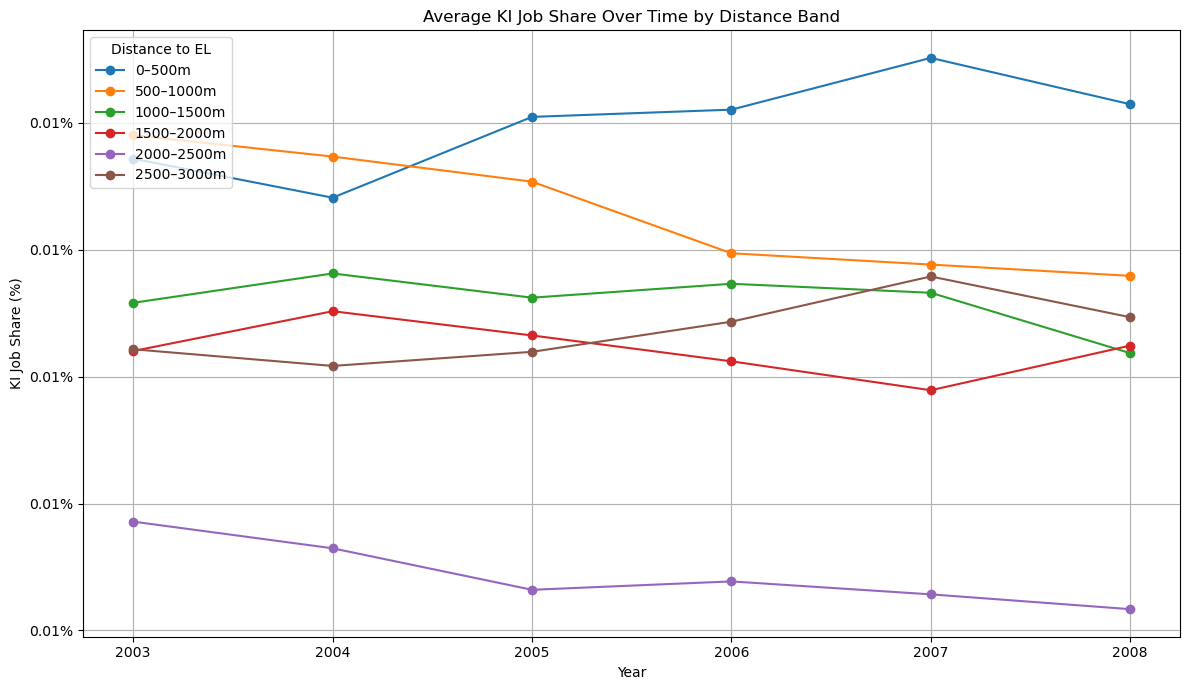

In [158]:
# Define distance bands (reused if already done)
bin_edges = [0, 500, 1000, 1500, 2000, 2500, 3000]
lsoa_ncaz['distance_band'] = pd.cut(lsoa_ncaz['network_distance_to_EL'], bins=bin_edges)

# Melt to long format
share_cols = sorted([col for col in lsoa_ncaz.columns if col.startswith('share_')])
long_df = lsoa_ncaz[['distance_band'] + share_cols].melt(
    id_vars='distance_band',
    value_vars=share_cols,
    var_name='year',
    value_name='share'
)
long_df['year'] = long_df['year'].str.extract(r'share_(\d+)')[0].astype(int) + 2000
long_df = long_df.dropna()

# Group by distance band and year
avg_df = long_df.groupby(['distance_band', 'year'])['share'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 7))
for band in avg_df['distance_band'].dropna().unique():
    band_data = avg_df[avg_df['distance_band'] == band]
    label = f"{int(band.left)}–{int(band.right)}m"
    plt.plot(band_data['year'], band_data['share'] * 100, label=label, marker='o')

plt.xlabel("Year")
plt.ylabel("KI Job Share (%)")
plt.title("Average KI Job Share Over Time by Distance Band")
plt.legend(title="Distance to EL", loc = "upper left")
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y:.2f}%'))
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Define distance bands
bin_edges = [0, 500, 1000, 1500, 2000, 2500, 3000]
lsoa_ncaz['distance_band'] = pd.cut(lsoa_ncaz['network_distance_to_EL'], bins=bin_edges)

# Melt to long format
count_cols = sorted([col for col in lsoa_ncaz.columns if col.startswith('count_')])
long_df = lsoa_ncaz[['distance_band'] + count_cols].melt(
    id_vars='distance_band',
    value_vars=count_cols,
    var_name='year',
    value_name='count'
)
long_df['year'] = long_df['year'].str.extract(r'count_(\d+)')[0].astype(int) + 2000
long_df = long_df.dropna()

# Group by distance band and year
avg_df = long_df.groupby(['distance_band', 'year'])['count'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 7))
for band in avg_df['distance_band'].dropna().unique():
    band_data = avg_df[avg_df['distance_band'] == band]
    label = f"{int(band.left)}–{int(band.right)}m"
    plt.plot(band_data['year'], band_data['count'], label=label, marker='o')

plt.xlabel("Year")
plt.ylabel("Avg KI Job Count per LSOA")
plt.title("Average KI Job Count Over Time by Distance Band")
plt.legend(title="Distance to EL")
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))  # optional: comma formatting
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_12873/2981897628.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_df = long_df.groupby(['distance_band', 'year'])['count'].mean().reset_index()


/tmp/ipykernel_12873/1785672642.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_df = long_df.groupby(['distance_band', 'year'])['share'].mean().reset_index()


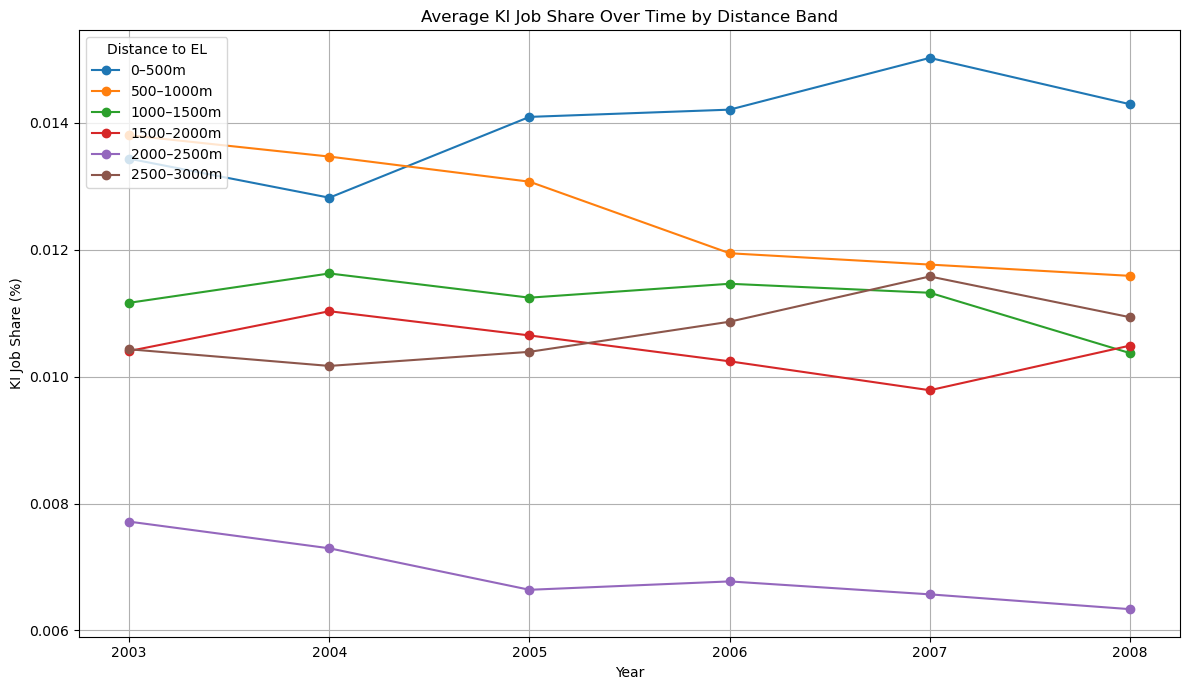

In [159]:
# Define distance bands (reused if already done)
bin_edges = [0, 500, 1000, 1500, 2000, 2500, 3000]
lsoa_ncaz['distance_band'] = pd.cut(lsoa_ncaz['network_distance_to_EL'], bins=bin_edges)

# Melt to long format
share_cols = sorted([col for col in lsoa_ncaz.columns if col.startswith('share_')])
long_df = lsoa_ncaz[['distance_band'] + share_cols].melt(
    id_vars='distance_band',
    value_vars=share_cols,
    var_name='year',
    value_name='share'
)
long_df['year'] = long_df['year'].str.extract(r'share_(\d+)')[0].astype(int) + 2000
long_df = long_df.dropna()

# Group by distance band and year
avg_df = long_df.groupby(['distance_band', 'year'])['share'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 7))
for band in avg_df['distance_band'].dropna().unique():
    band_data = avg_df[avg_df['distance_band'] == band]
    label = f"{int(band.left)}–{int(band.right)}m"
    plt.plot(band_data['year'], band_data['share'] * 100, label=label, marker='o')

plt.xlabel("Year")
plt.ylabel("KI Job Share (%)")
plt.title("Average KI Job Share Over Time by Distance Band")
plt.legend(title="Distance to EL", loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()